In [1]:
import pandas as pd

# Load the CSV file
data_df = pd.read_csv(r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\train.csv')

# Map the diagnosis to categorical labels
diagnosis_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}
data_df['label'] = data_df['diagnosis'].map(diagnosis_mapping)

# Print a few sample records to check the dataset
print(data_df.head())


        id_code  diagnosis           label
0  000c1434d8d7          2        Moderate
1  001639a390f0          4  Proliferate_DR
2  0024cdab0c1e          1            Mild
3  002c21358ce6          0           No_DR
4  005b95c28852          0           No_DR


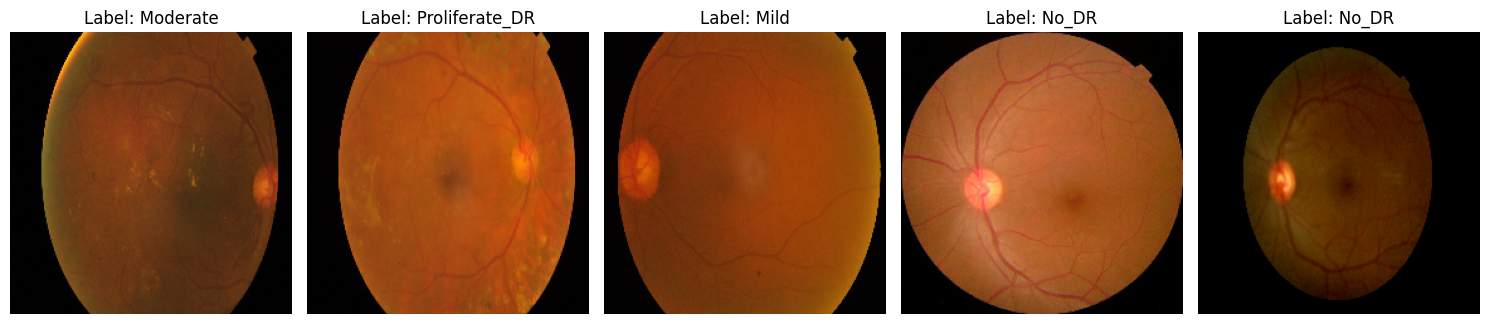

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def load_and_display_samples(image_directory, dataframe, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    axes = axes.flatten()
    
    for idx, ax in enumerate(axes):
        row = dataframe.iloc[idx]
        folder_name = diagnosis_mapping[row['diagnosis']]
        img_path = os.path.join(image_directory, folder_name, row['id_code'] + '.png')
        
        image = Image.open(img_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Label: {row['label']}")
    
    plt.tight_layout()
    plt.show()

# Define the path to your image directory
image_directory = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images'

# Call the function to display 5 sample images
load_and_display_samples(image_directory, data_df, num_samples=5)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=40,  # Rotate images randomly by 40 degrees
    width_shift_range=0.2,  # Horizontally shift images by 20%
    height_shift_range=0.2,  # Vertically shift images by 20%
    shear_range=0.2,  # Apply shearing transformations
    zoom_range=0.2,  # Apply random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill empty pixels after a transformation
)

# Define the generator for the training dataset
train_gen = datagen.flow_from_directory(
    r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Define a separate generator for the validation dataset without augmentation
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_gen = val_datagen.flow_from_directory(
    r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images',  # Adjust if you have a separate validation set
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


Found 3662 images belonging to 5 classes.
Found 3662 images belonging to 5 classes.


In [4]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

# Custom preprocessing function
def preprocess_image(image):
    # Convert image to numpy array
    image_array = img_to_array(image)

    # Apply Gaussian blur (kernel size 5x5)
    blurred_image = cv2.GaussianBlur(image_array, (5, 5), 0)

    # Convert to LAB color space for contrast adjustment
    lab_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2LAB)
    
    # Apply contrast adjustment
    l_channel, a, b = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)

    # Merge back the LAB channels and convert back to RGB
    lab_image = cv2.merge((l_channel, a, b))
    final_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    # Rescale values to [0, 1]
    final_image = final_image / 255.0

    return final_image

# Custom preprocessing function wrapper
def custom_preprocessing(image):
    image = array_to_img(image)
    processed_image = preprocess_image(image)
    return img_to_array(processed_image)

# Custom ImageDataGenerator with Gaussian Blur and Contrast Adjustment
class CustomImageDataGenerator(ImageDataGenerator):
    def standardize(self, image):
        if self.featurewise_center:
            image = custom_preprocessing(image)  # Apply custom preprocessing
        return super().standardize(image)

# Now define the Custom ImageDataGenerator
train_datagen = CustomImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    rotation_range=40,  # Rotate images randomly by 40 degrees
    width_shift_range=0.2,  # Horizontally shift images by 20%
    height_shift_range=0.2,  # Vertically shift images by 20%
    shear_range=0.2,  # Apply shearing transformations
    zoom_range=0.2,  # Apply random zoom
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill empty pixels after a transformation
)

# Define the generator for the training dataset with custom preprocessing
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Validation ImageDataGenerator without augmentation but with preprocessing
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_generator = val_datagen.flow_from_directory(
    r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images',  # Adjust if you have a separate validation set
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


Found 3662 images belonging to 5 classes.
Found 3662 images belonging to 5 classes.


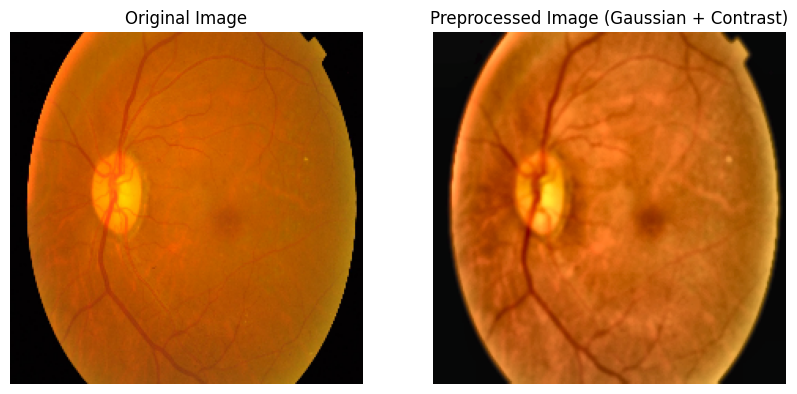

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to preprocess image (Gaussian blur + Contrast enhancement)
def preprocess_image(image_array):
    # Convert the image from RGB to BGR (OpenCV uses BGR by default)
    image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image_array, (5, 5), 0)

    # Convert to LAB color space for CLAHE
    lab_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab_image)

    # Apply CLAHE to the L-channel (luminance channel)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)

    # Merge back the LAB channels and convert back to RGB
    lab_image = cv2.merge((l_channel, a, b))
    preprocessed_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    return preprocessed_image

# Function to visualize original and preprocessed images
def visualize_preprocessing(image_path):
    # Load the image using Keras' load_img function
    image = load_img(image_path, target_size=(224, 224))
    
    # Convert to array
    image_array = img_to_array(image)
    
    # Convert to uint8 for compatibility with OpenCV
    image_array = image_array.astype('uint8')
    
    # Apply Gaussian blur and contrast adjustment (preprocessing)
    preprocessed_image = preprocess_image(image_array)
    
    # Plot original and preprocessed images
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_array.astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image.astype("uint8"))
    plt.title("Preprocessed Image (Gaussian + Contrast)")
    plt.axis("off")
    
    plt.show()

# Example: Replace this with a valid image path from your dataset
image_path = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images\Mild\0a61bddab956.png'
visualize_preprocessing(image_path)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 classes for diabetic retinopathy severity
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Data generator with preprocessing applied
def preprocessing_function(image):
    image = preprocess_image(image.astype('uint8'))  # Apply Gaussian + Contrast enhancement
    return image

# Define the data generator
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    preprocessing_function=preprocessing_function  # Apply preprocessing
)

# Load training and validation data
train_dir = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images'
val_dir = train_dir  # Assuming you don't have a separate validation dataset

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Train-test split (you can use a subset of data as validation)
validation_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


Found 3662 images belonging to 5 classes.
Found 3662 images belonging to 5 classes.


In [8]:
def preprocessing_function(image):
    image = preprocess_image(image.astype('uint8'))  # Apply Gaussian + Contrast enhancement
    image = image.astype('float32')  # Convert to float32 after preprocessing
    return image

# Define the data generator with the preprocessing function
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values
    preprocessing_function=preprocessing_function  # Apply preprocessing
)

# Load training and validation data
train_dir = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images'

# Training generator
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Validation generator (same as training directory if validation set is the same)
validation_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Calculate steps per epoch
steps_per_epoch_train = train_gen.samples // train_gen.batch_size
steps_per_epoch_val = validation_gen.samples // validation_gen.batch_size

# Define callbacks for saving the model and early stopping
checkpoint = ModelCheckpoint('diabetic_retinopathy_model_3.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model again
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=validation_gen,
    validation_steps=steps_per_epoch_val,
    epochs=9,
    callbacks=[checkpoint, early_stop]
)


Found 3662 images belonging to 5 classes.
Found 3662 images belonging to 5 classes.
Epoch 1/9


C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.6096 - loss: 1.1456 - val_accuracy: 0.7083 - val_loss: 0.8023
Epoch 2/9
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.6250 - loss: 0.9224 - val_accuracy: 0.7143 - val_loss: 0.8460
Epoch 3/9


c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


114/114 ━━━━━━━━━━━━━━━━━━━━ 110s 955ms/step - accuracy: 0.6956 - loss: 0.8187 - val_accuracy: 0.7193 - val_loss: 0.7540
Epoch 4/9
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6875 - loss: 0.7253 - val_accuracy: 0.7857 - val_loss: 0.5452
Epoch 5/9
114/114 ━━━━━━━━━━━━━━━━━━━━ 112s 980ms/step - accuracy: 0.7307 - loss: 0.7569 - val_accuracy: 0.7262 - val_loss: 0.7260
Epoch 6/9
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7812 - loss: 0.6243 - val_accuracy: 0.7143 - val_loss: 0.8060
Epoch 7/9
114/114 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7356 - loss: 0.7491 - val_accuracy: 0.7503 - val_loss: 0.6872
Epoch 8/9
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 968us/step - accuracy: 0.7188 - loss: 0.6414 - val_accuracy: 0.7143 - val_loss: 0.6316
Epoch 9/9
114/114 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7360 - loss: 0.7025 - val_accuracy: 0.7412 - val_loss: 0.6359


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


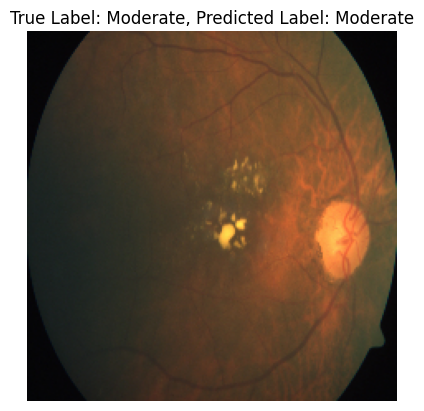

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


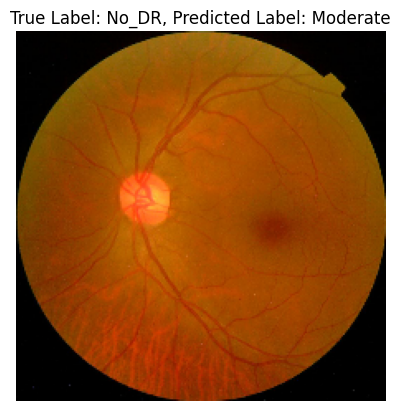

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


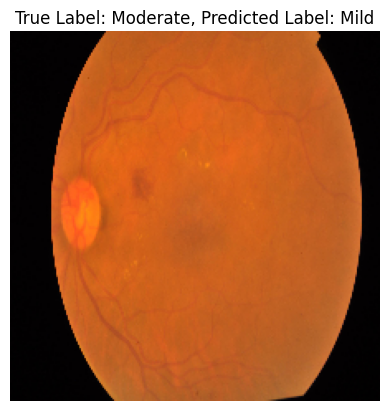

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


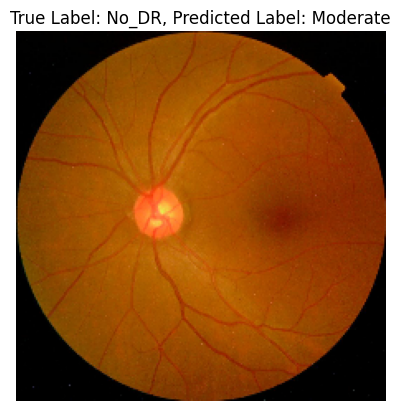

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


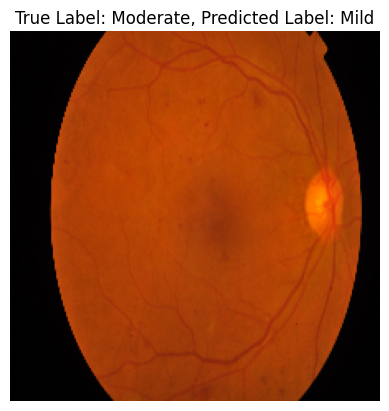

In [14]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import os

# Load the trained model
model = load_model('diabetic_retinopathy_model_3.keras')

# Label mapping
label_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}

# Load your train.csv for true labels
train_df = pd.read_csv(r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\train.csv')
train_df['label'] = train_df['diagnosis'].map(label_mapping)

# Preprocessing function including Gaussian blur and contrast adjustment
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(224, 224))  # Load image and resize
    image = img_to_array(image)  # Convert image to array
    image = preprocess_image_gaussian_contrast(image.astype('uint8'))  # Apply Gaussian + Contrast enhancement
    image = image.astype('float32') / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Function for applying Gaussian blur and contrast adjustment
def preprocess_image_gaussian_contrast(image):
    import cv2
    # Convert to LAB and apply contrast adjustment
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel = clahe.apply(l_channel)
    lab_image = cv2.merge((l_channel, a, b))
    image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)
    
    # Apply Gaussian blur
    image = cv2.GaussianBlur(image, (0, 0), sigmaX=10)
    return image

# Prediction function with true label comparison
def predict_image(image_id, label):
    # Construct image path
    image_path = os.path.join(r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images', label, f'{image_id}.png')

    # Preprocess image
    preprocessed_image = preprocess_image(image_path)
    
    # Make prediction
    prediction = model.predict(preprocessed_image)
    
    # Get the predicted class index and label
    predicted_class = np.argmax(prediction, axis=1)[0]
    predicted_label = label_mapping[predicted_class]
    
    # Display the original image with true and predicted labels
    original_image = load_img(image_path, target_size=(224, 224))
    plt.imshow(original_image)
    plt.title(f"True Label: {label}, Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()
    
    # Return predicted and true labels for logging
    return label, predicted_label

# Example usage for comparison
for idx, row in train_df.sample(5).iterrows():  # Sample 5 images from the train data
    true_label = label_mapping[row['diagnosis']]
    predict_image(row['id_code'], true_label)


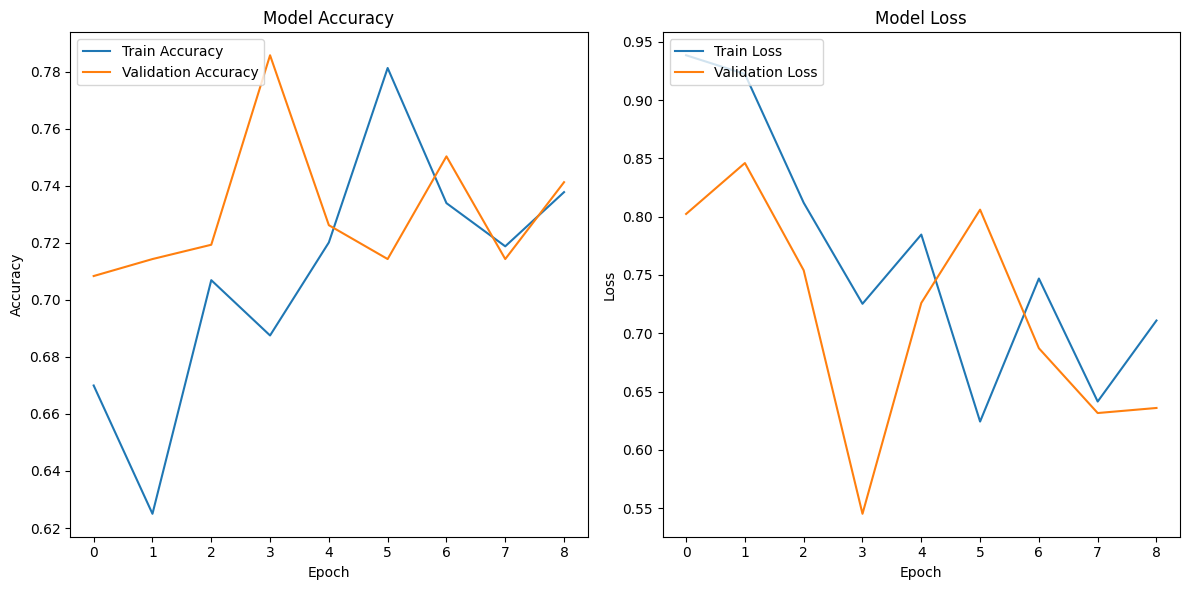

In [15]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss graphs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


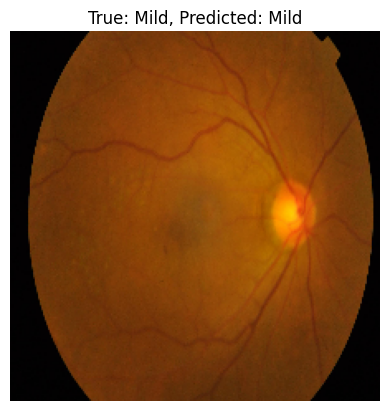

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


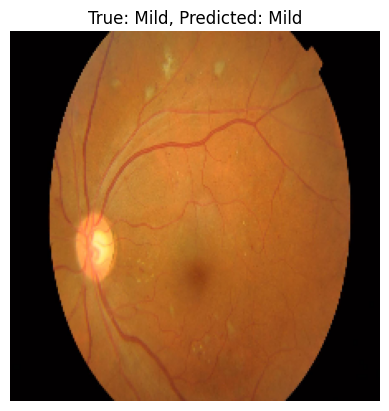

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


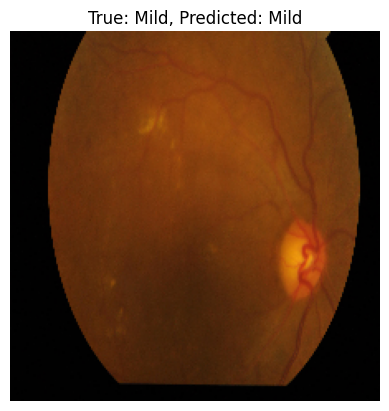

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


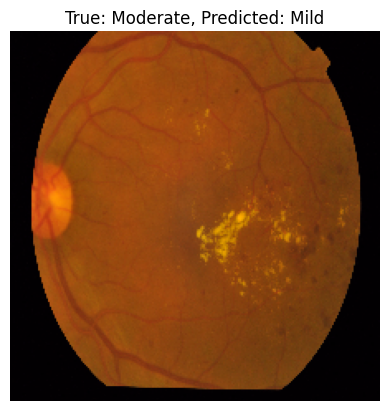

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


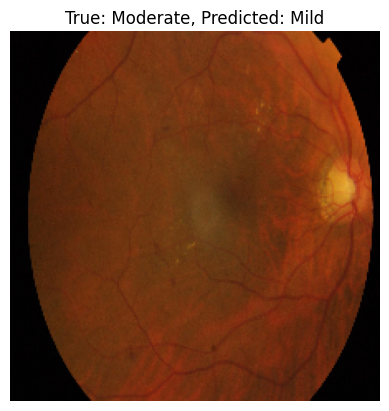

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


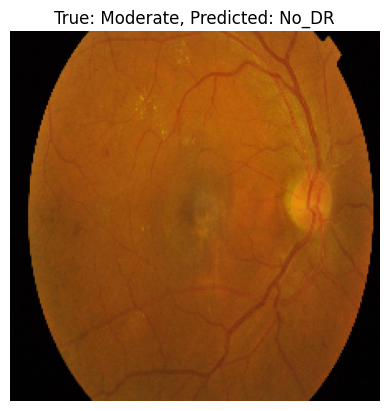

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


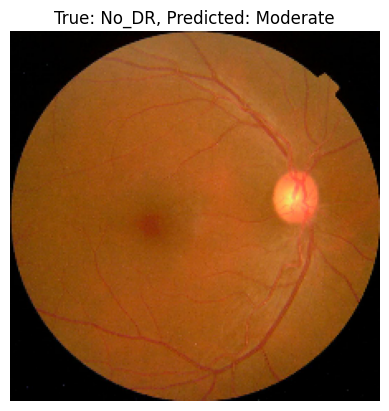

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


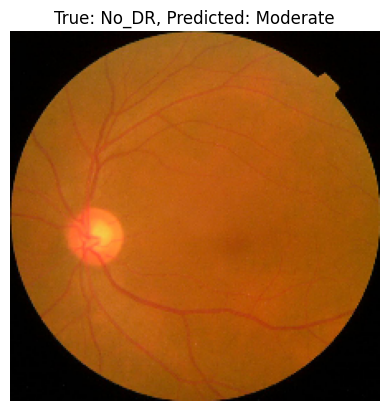

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


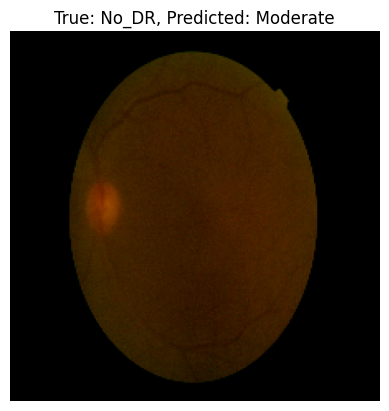

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


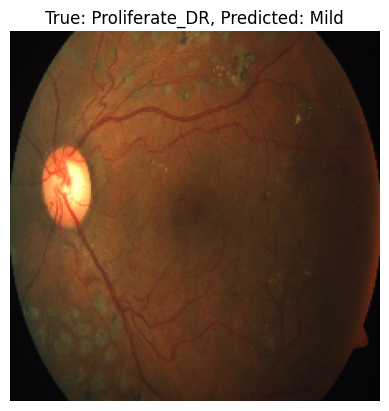

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


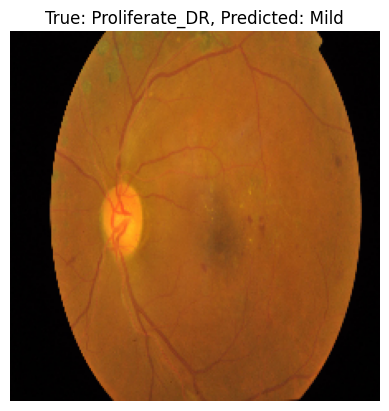

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


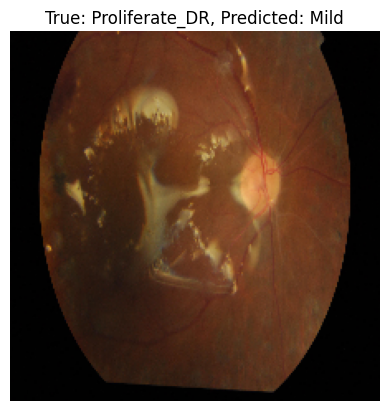

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


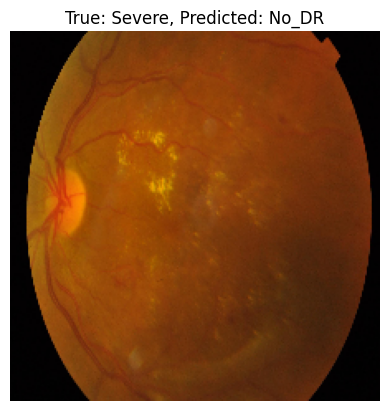

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


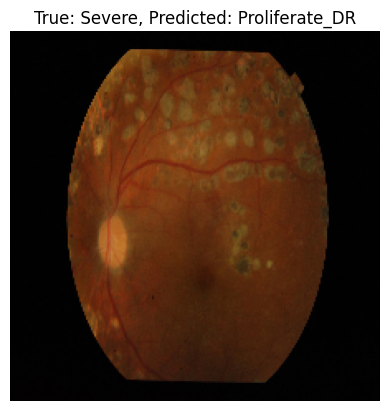

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


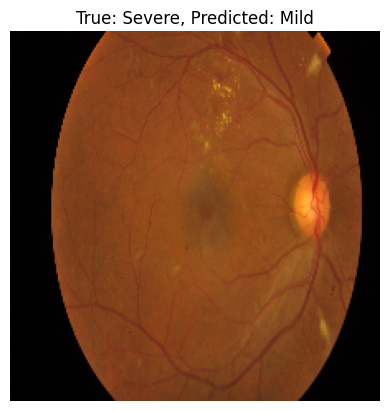

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import random
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define class mapping
class_mapping = {0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}

# Load training directory
train_dir = r'C:\Users\spars\Desktop\SEM 5\AIOT\Diabetic_Retinopathy_Detection_Project\Retinopathy_Dataset\colored_images'

# Get 2-3 images from each folder (class)
num_samples_per_class = 3  # Number of samples per class
samples = []  # To store selected samples and labels

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        all_images = os.listdir(class_path)
        selected_images = random.sample(all_images, num_samples_per_class)  # Randomly select images
        for image_name in selected_images:
            image_path = os.path.join(class_path, image_name)
            label = class_name
            samples.append((image_path, label))

# Prepare images for prediction
predicted_labels = []
true_labels = []

for image_path, true_label in samples:
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))  # Load image and resize
    image = img_to_array(image)  # Convert image to array
    image = image.astype('float32') / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Expand dimensions to match input shape

    # Predict the label
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction, axis=1)[0]

    # Append the predictions and true labels
    predicted_labels.append(predicted_label)
    true_labels.append(list(class_mapping.values()).index(true_label))  # Convert label to numerical value

    # Display image and prediction
    plt.imshow(img_to_array(load_img(image_path)) / 255.0)
    plt.title(f'True: {true_label}, Predicted: {class_mapping[predicted_label]}')
    plt.axis('off')
    plt.show()

# Convert to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)


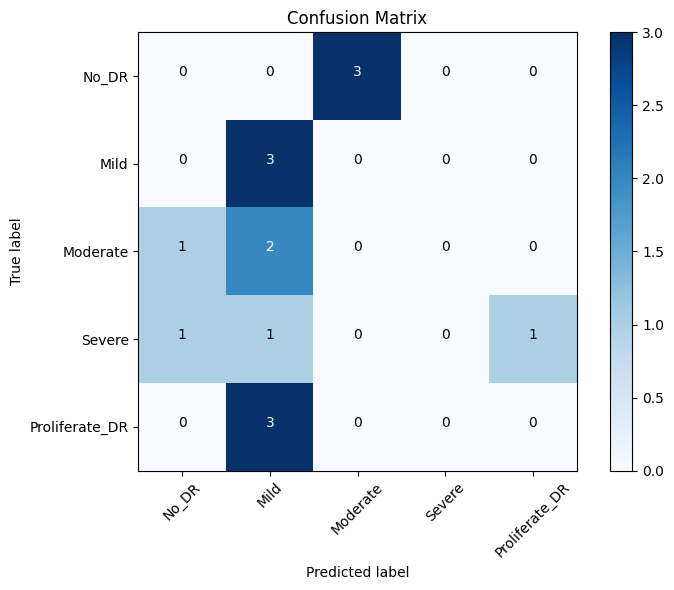

Classification Report:
                 precision    recall  f1-score   support

         No_DR       0.00      0.00      0.00         3
          Mild       0.33      1.00      0.50         3
      Moderate       0.00      0.00      0.00         3
        Severe       0.00      0.00      0.00         3
Proliferate_DR       0.00      0.00      0.00         3

      accuracy                           0.20        15
     macro avg       0.07      0.20      0.10        15
  weighted avg       0.07      0.20      0.10        15



C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\spars\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [27]:

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_mapping))
plt.xticks(tick_marks, class_mapping.values(), rotation=45)
plt.yticks(tick_marks, class_mapping.values())

# Plot the values inside the matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=class_mapping.values()))
